In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import flashbax as fbx
from flashbax.vault import Vault
from scipy.stats import norm
import matplotlib.pyplot as plt
import copy
import flashbax
from flashbax.buffers.trajectory_buffer import TrajectoryBufferState

# Sampling a distribution over return from a dataset of episodes
The goal:
- Quantify the exploration/exploitation of the dataset-generating policy
- See if that has an effect on training.


In [ ]:
# vlt = Vault(rel_dir="vaults", vault_name="qmix_2s3z_42", vault_uid="20240409151430")
rel_dir="vaults/smac_v2/terran_5_vs_5"
vault_name="500_000"
uids = ["Replay","Random"]

for uid in uids:
    vlt = Vault(rel_dir=rel_dir, vault_name=vault_name, vault_uid=uid)
    all_data = vlt.read()
    offline_data = all_data.experience
    del vlt
    del all_data

    vals, indices, counts, rewards = get_unique_obs_actions_with_reward(offline_data,return_per_agent=True)

    with open(rel_dir+"/"+vault_name+"/"+uid+"/count_info.pickle","wb") as f:
        pickle.dump((vals,indices,counts, rewards),f)

    del vlt

# get an OG-MARL dataset
rel_dir = "vaults/smac_v2"
vault_name = "terran_5_vs_5.vlt"
vault_uid="Random"

vlt = Vault(rel_dir=rel_dir, vault_name=vault_name, vault_uid=vault_uid)

# the info we want - episode length, start idx and end idx
len_start_end = get_length_start_end(vlt)

In [55]:
# cumulative summing per-episode
def get_episode_returns_and_term_idxes(vlt):
    all_data = vlt.read()
    offline_data = all_data.experience

    rewards = offline_data['rewards'][0, :, 0]
    terminal_flag = offline_data['terminals'][0, :, ...].all(axis=-1)

    assert terminal_flag[-1]==True

    def scan_cumsum(return_so_far,prev_term_reward):
        term, reward = prev_term_reward
        return_so_far = return_so_far*(1-term)+ reward
        return return_so_far, return_so_far
    
    xs = (terminal_flag[:-1], rewards[1:])
    
    _, cumsums = jax.lax.scan(scan_cumsum, rewards[0],xs)

    term_idxes = np.argwhere(terminal_flag)

    # shift back as we did for the loop
    return cumsums[term_idxes-1], term_idxes

In [56]:
# first store indices of episodes, then sort by episode return.
# outputs return, start, end and vault index in vault list
def sort_concat(returns,eps_ends, ids):

    episode_start_idxes = eps_ends[:-1]+1
    episode_start_idxes = jnp.insert(episode_start_idxes,0,0).reshape(-1,1)
    sorting_idxes = jnp.lexsort(jnp.array([returns[:,0]]), axis=-1)
    # print(sorting_idxes)

    return_start_end = jnp.concatenate([returns,episode_start_idxes.reshape(-1,1),eps_ends,ids],axis=-1)

    # return, start, end sorted by return value ascending
    sorted_return_start_end = return_start_end[sorting_idxes]
    return sorted_return_start_end

In [57]:
# given bin edges and a sorted array of values, get the bin number per value
def get_bin_numbers(sorted_values,bin_edges):
    bin_numbers = np.zeros_like(sorted_values)
    
    def get_bin_number(bin_num,value):
        is_overflowing = value>bin_edges[bin_num]

        if is_overflowing:
            bin_num += 1
            is_doubly_overflowing = value>bin_edges[bin_num]
            if is_doubly_overflowing:
                bin_num = get_bin_number(bin_num,value)
            
        return bin_num
    
    bin_bookmark = 0

    for i,val in enumerate(sorted_values):
        bin_bookmark = get_bin_number(bin_bookmark,val)
        bin_numbers[i] = bin_bookmark

    return bin_numbers

In [58]:
# sample from pdf according to heights
# BIG NOTE: CHECK THE DISPARITY, OTHERWISE YOUR DISTRIBUTION WILL BE TOO MUCH
def episode_idxes_sampled_from_pdf(pdf,bar_heights):
    num_to_sample = np.round(pdf).astype(int)
    sample_range_edges = np.concatenate([[0],np.cumsum(bar_heights)])

    assert num_to_sample.shape==bar_heights.shape

    target_sample_idxes = []
    for i,n_sample in enumerate(num_to_sample):
            sample_base = np.arange(sample_range_edges[i],sample_range_edges[i+1])
            print(sample_base)
            if n_sample<=0:
                 pass
            # if we sample more than all in the bar
            else:
                if n_sample>=bar_heights[i]:
                    sample_rest = np.random.choice(sample_base,n_sample-bar_heights[i],replace=True)
                    sample = np.concatenate([sample_base,sample_rest])
                else:
                    sample = np.random.choice(sample_base,n_sample,replace=True) #make false for no replace
                target_sample_idxes = target_sample_idxes+list(np.sort(sample))
    return target_sample_idxes

In [59]:
def sanity_check(sampled_idxes,returns):
    vals = np.array([returns[i] for i in sampled_idxes])
    return np.mean(vals), np.std(vals)

In [60]:
def preprocess(rel_dir,vault_name):
    vlts = get_all_vaults(rel_dir, vault_name)

    # get returns, term idxes for each episode per vault
    returns_list = []
    episode_end_list = []
    vault_ids = []
    for j,vault in enumerate(vlts):
        print(j)
        returns, episode_end_idxes = get_episode_returns_and_term_idxes(vault)
        returns_list.append(returns)
        episode_end_list.append(episode_end_idxes)
        vault_ids.append(jnp.zeros_like(returns)+j)

    # make np compatible
    all_returns = jnp.concatenate(returns_list)
    all_episode_end_idxes = jnp.concatenate(episode_end_list)
    all_vault_ids = jnp.concatenate(vault_ids)

    # concatenate then sort all results
    all_sorted_return_start_end = sort_concat(all_returns,all_episode_end_idxes, all_vault_ids)
    return vlts, all_sorted_return_start_end

In [61]:
def bin_processed_data(all_sorted_return_start_end, n_bins=500):
    # get bin edges, including final endpoint
    bin_edges = jnp.linspace(start=min(min(all_sorted_return_start_end[:,0]),0), stop = max(all_sorted_return_start_end[:,0]), num=n_bins,endpoint=True)
    print(all_sorted_return_start_end.shape[0])

    # get bin numbers
    bin_numbers = get_bin_numbers(all_sorted_return_start_end[:,0], bin_edges)
    print(bin_numbers.shape[0])

    bar_labels, bar_heights= np.unique(bin_numbers,return_counts=True)

    padded_heights = np.zeros(n_bins)
    for bar_l, bar_h in zip(bar_labels,bar_heights):
        padded_heights[int(bar_l)] = bar_h

    return bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers
        

# Main: for plugging different datasets and playing
Here, we use the above. We:
- Preprocess datasets
- Bin them etc
- Figure out distribution
- Package them again

## Preprocess and bin

In [62]:
# get base vaults
vlts, all_sorted_return_start_end = preprocess(rel_dir="vaults", vault_name="2halfcheetah.vlt")

Loading vault found at /home/louise/workspace/og-marl/development/vaults/2halfcheetah.vlt/Good
Loading vault found at /home/louise/workspace/og-marl/development/vaults/2halfcheetah.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/development/vaults/2halfcheetah.vlt/Poor
0
1
2


In [63]:
print(all_sorted_return_start_end)

[[-1.9148645e+02  5.5500000e+05  5.5599900e+05  2.0000000e+00]
 [-1.7016428e+02  2.9200000e+05  2.9299900e+05  2.0000000e+00]
 [-1.6404582e+02  5.9700000e+05  5.9799900e+05  2.0000000e+00]
 ...
 [ 9.0094395e+03  3.1900000e+05  3.1999900e+05  0.0000000e+00]
 [ 9.0690869e+03  3.1400000e+05  3.1499900e+05  0.0000000e+00]
 [ 9.1322471e+03  3.2700000e+05  3.2799900e+05  0.0000000e+00]]


In [64]:
bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers = bin_processed_data(all_sorted_return_start_end, n_bins=500)

3000
3000


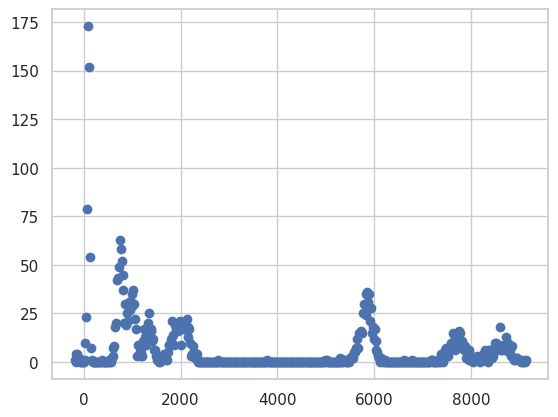

In [65]:
plt.scatter(bin_edges,padded_heights)
plt.show()

In [66]:
print(bar_labels)
print(bar_heights)
print(np.cumsum(bar_heights))#-bar_heights)

[  0.   2.   3.   4.   5.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  30.  38.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.
  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.
  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.
  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  94.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 159. 213.
 277. 279. 294. 298. 299. 302. 305. 306. 307. 308. 309. 310. 311. 312.
 313. 314. 315. 316. 317. 318. 319. 320. 321. 322. 323. 324. 325. 326.
 327. 328. 329. 330. 331. 332. 333. 334. 335. 336. 337. 339. 340. 342.
 343. 365. 373. 394. 395. 396. 402. 405. 406. 407. 409. 410. 411. 412.
 413. 414. 415. 416. 417. 418. 419. 420. 421. 422. 423. 424. 425. 426.
 427. 428. 429. 430. 431. 432. 433. 434. 435. 436. 437. 438. 439. 440.
 442. 

[0]
[1 2 3 4]
[5 6 7 8]
[9]
[10 11]
[12]
[13 14 15 16 17 18 19 20 21 22]
[23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[ 46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124]
[125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 25

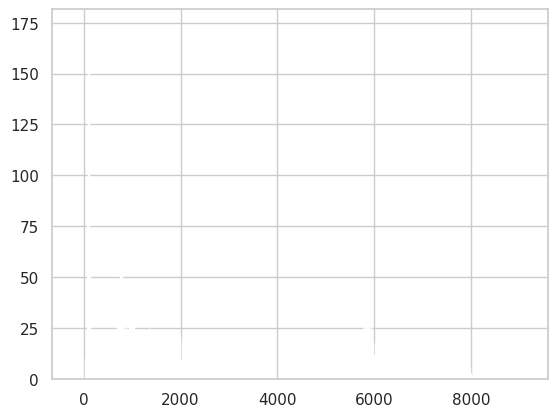

In [67]:
dummy_idxes = episode_idxes_sampled_from_pdf(bar_heights-1,bar_heights)
print(dummy_idxes)
# print(np.where(np.arange(121096)!=dummy_idxes))
dummy_return_start_etc = all_sorted_return_start_end[dummy_idxes,:]
# print(dummy_return_start_etc)
bar_l, bar_h, padded_h, bin_e, bin_nums = bin_processed_data(dummy_return_start_etc, n_bins=50)
plt.bar(bin_edges,padded_heights)
plt.show()

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 12 21 14  9 19 17 17 16 19 19 21  9 18 17 18 17
 17 22 13 18 17 10  3  4  8  5  2  2  4  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  9  6  6  7  8 17  5  5  7  8  5 12  8  5  9  3  4  1  6  0  0  0
  0  0  0  0  0  0  0  0]
[ 1  4  4  1  2  1 10 10 10 10 10 10  7  1  1  1  2  3  7  8 18 20 10 10
 10 10 10 10 10 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 

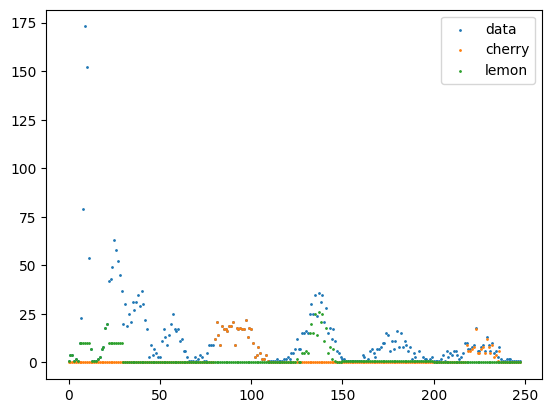

[0]
[1 2 3 4]
[5 6 7 8]
[9]
[10 11]
[12]
[13 14 15 16 17 18 19 20 21 22]
[23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[ 46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124]
[125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 25

In [40]:
# # for 2halfcheetah
# cherry_picked = np.zeros_like(bar_heights)
# cherry_picked[80:110] = bar_heights[80:110]
# cherry_picked[-30:-15] = bar_heights[-30:-15]-1
# cherry_picked[-15:] = bar_heights[-15:]-2
# cherry_picked[np.where(cherry_picked<0)] = 0

# lemon_picked = np.zeros_like(bar_heights)
# lemon_picked[120:150] = bar_heights[120:150]-10
# lemon_picked[150:200] = 1 #bar_heights[120:150]
# lemon_picked[:30] = bar_heights[:30]
# lemon_picked[np.where(lemon_picked[:30]>20)]=10
# lemon_picked[np.where(lemon_picked<0)] = 0
# print(cherry_picked)
# print(lemon_picked)
# print(np.sum(cherry_picked))
# print(np.sum(lemon_picked))
# plt.scatter(range(len(bar_labels)),bar_heights,s=1,label="data")
# plt.scatter(range(len(bar_labels)),cherry_picked,s=1,label="cherry")
# plt.scatter(range(len(bar_labels)),lemon_picked,s=1,label="lemon")
# plt.legend()
# plt.show()

# cherry_picked_idxes =  episode_idxes_sampled_from_pdf(cherry_picked,bar_heights)
# lemon_picked_idxes =  episode_idxes_sampled_from_pdf(lemon_picked,bar_heights)

# mean, std = sanity_check(cherry_picked_idxes,all_sorted_return_start_end[:,0])
# print(mean)
# print(std)
# mean, std = sanity_check(lemon_picked_idxes,all_sorted_return_start_end[:,0])
# print(mean)
# print(std)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   10   10
   10   10   10   10   10   10   10   10   10   10   10   10   10   10
   10  877 3156  561 3528    0  322 3274    0  160 2694  727    0   94
 1987 1512   40 1417 2107    0    5    5    5    5    5    5    5    5
    5    5    5    5    5    5    5    5    5    5    5    5    5    5
    5    5    5    5    0   50  500]
[   6    1    1    1    1    1    2    1    1    5    2   11   16   20
   34   27    1   64   93    4   83  199   25  117  396   83  108    0
  226   73  816  518   44  817    0   17  723    0   13  618    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  166 1642    0   85 1352  368    0   52
  998  761   25  713 1058    8  451 1282    2  257    0    2  232 3131
   78 3346   36 3492   12 1361  647    0

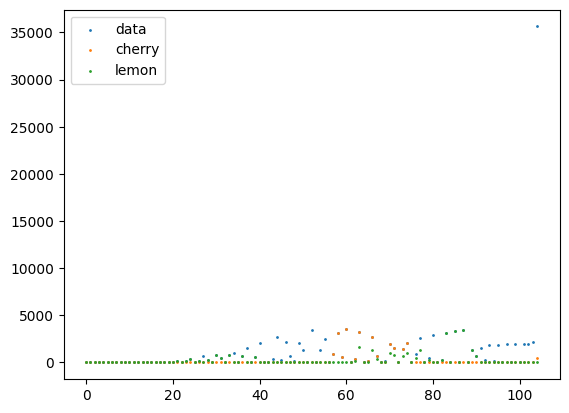

[0 1 2 3 4 5]
[6]
[7]
[8]
[9]
[10]
[11 12]
[13]
[14]
[15 16 17 18 19]
[20 21]
[22 23 24 25 26 27 28 29 30 31 32]
[33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
[49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
[ 69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102]
[103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129]
[130]
[131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194]
[195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255 256 257 25

In [32]:
# for 5m_vs_6m NB

# cherry_picked = np.zeros_like(bar_heights)
# cherry_picked[40:57] = 10
# cherry_picked[57:75] = bar_heights[57:75]-10
# cherry_picked[76:-3] = 5# cherry_picked[57:75] = bar_heights[57:75]-10

# cherry_picked[-2] = 50
# cherry_picked[-1] = 500
# cherry_picked[np.where(cherry_picked<0)] = 0

# lemon_picked = np.zeros_like(bar_heights)
# lemon_picked[59:80] = bar_heights[59:80]*0.5
# lemon_picked[81:91] = bar_heights[81:91]
# lemon_picked[0:40] = bar_heights[0:40]
# lemon_picked[27] = 0
# lemon_picked[34] = 0
# lemon_picked[37] = 0
# lemon_picked[np.where(lemon_picked<0)] = 0
# print(cherry_picked)
# print(lemon_picked)
# print(np.sum(cherry_picked))
# print(np.sum(lemon_picked))
# plt.scatter(range(len(bar_labels)),bar_heights,s=1,label="data")
# plt.scatter(range(len(bar_labels)),cherry_picked,s=1,label="cherry")
# plt.scatter(range(len(bar_labels)),lemon_picked,s=1,label="lemon")
# plt.legend()
# plt.show()

# cherry_picked_idxes =  episode_idxes_sampled_from_pdf(cherry_picked,bar_heights)
# lemon_picked_idxes =  episode_idxes_sampled_from_pdf(lemon_picked,bar_heights)

# mean, std = sanity_check(cherry_picked_idxes,all_sorted_return_start_end[:,0])
# print(mean)
# print(std)
# mean, std = sanity_check(lemon_picked_idxes,all_sorted_return_start_end[:,0])
# print(mean)
# print(std)

## Now we store again, and verify it collects the correct data for storage

In [59]:
def stitch_vault_from_sampled_episodes_(vlts, return_start_end_sample, vault_name):

    all_data = vlts[0].read()
    offline_data = all_data.experience

    dest_buffer = fbx.make_trajectory_buffer(
        # Sampling parameters
        sample_batch_size=1,
        sample_sequence_length=1,
        period=1,
        # Not important in this example, as we are not adding to the buffer
        max_length_time_axis=500_000,
        min_length_time_axis=100,
        add_batch_size=1,
    )

    dummy_experience = jax.tree_map(lambda x: x[0, 0, ...], all_data.experience)
    del offline_data
    del all_data

    dest_state = dest_buffer.init(dummy_experience)
    buffer_add = jax.jit(dest_buffer.add, donate_argnums=0)
    dest_vault = flashbax.vault.Vault(
        experience_structure=dest_state.experience,
        vault_name=vault_name,
    )

    for vault_id, vlt in enumerate(vlts):
        samples_frm_this_vault = return_start_end_sample[np.where(return_start_end_sample[:,-1]==vault_id)]
        starts = samples_frm_this_vault[:,1]
        ends = samples_frm_this_vault[:,2]

        all_data = vlt.read()
        offline_data = all_data.experience

        for start,end in zip(starts,ends):
            sample_experience = jax.tree_util.tree_map(lambda x: x[:,int(start):int(end+2),...],offline_data)
            dest_state = buffer_add(dest_state, sample_experience)
        
        timesteps_written = dest_vault.write(dest_state)

        print(timesteps_written)
        del offline_data
        del all_data     
    return 

In [60]:
# cumulative summing per-episode
def get_episode_returns_and_term_idxes(vlt):
    all_data = vlt.read()
    offline_data = all_data.experience

    rewards = offline_data['rewards'][0, :, 0]
    terminal_flag = offline_data['terminals'][0, :, ...].all(axis=-1)

    assert terminal_flag[-1]==True

    def scan_cumsum(return_so_far,prev_term_reward):
        term, reward = prev_term_reward
        return_so_far = return_so_far*(1-term)+ reward
        return return_so_far, return_so_far
    
    xs = (terminal_flag[:-1], rewards[1:])
    
    _, cumsums = jax.lax.scan(scan_cumsum, rewards[0],xs)

    term_idxes = np.argwhere(terminal_flag)

    # shift back as we did for the loop
    return cumsums[term_idxes-1], term_idxes

In [61]:
def get_episode_plus(sample_rse,plus):

    all_data = vlts[int(sample_rse[-1])].read()
    offline_data = all_data.experience

    sample_experience = jax.tree_util.tree_map(lambda x: x[:,int(sample_rse[1]):int(sample_rse[2]+1+plus),...],offline_data)

    del offline_data
    
    rewards = sample_experience['rewards'][0, :, 0]
    terminal_flag = sample_experience['terminals'][0, :, ...].all(axis=-1)

    return rewards, terminal_flag

In [62]:
idxes = [cherry_picked_idxes[-3]]
print(cherry_picked_idxes[-3])
for idx in idxes:
    rew, term = get_episode_plus(all_sorted_return_start_end[idx,:],1)
    print(term)
    print(rew)
    print(all_sorted_return_start_end[idx,0])

2982
[False False False ... False  True False]
[-0.5929605  -1.4470978  -0.59556985 ...  8.597724   10.015313
 -0.46539786]
8846.424


In [64]:
cherry_picked_samples = all_sorted_return_start_end[cherry_picked_idxes,:]
lemon_picked_samples = all_sorted_return_start_end[lemon_picked_idxes,:]

vault_name = "cherry_lemon_cheetah"
sample_experience = stitch_vault_from_sampled_episodes_(vlts,cherry_picked_samples,vault_name)

New vault created at /home/louise/workspace/og-marl/development/vaults/cherry_lemon_cheetah/20240403135033
Since the provided buffer state has a temporal dimension of 500000, you must write to the vault at least every 499999 timesteps to avoid data loss.
134134
386386
0


Loading vault found at /home/louise/workspace/og-marl/development/vaults/smac_v1_cl/5m_vs_6m.vlt/lemon
Loading vault found at /home/louise/workspace/og-marl/development/vaults/smac_v1_cl/5m_vs_6m.vlt/cherry


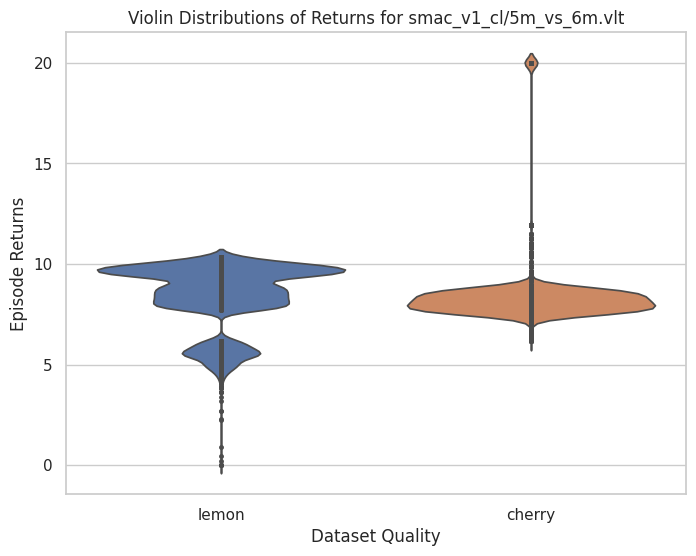

{'lemon': Array([ 0.       ,  0.       ,  2.3018868, ..., 10.339623 , 10.339623 ,
        10.339623 ], dtype=float32),
 'cherry': Array([ 7.54717 ,  7.54717 ,  7.54717 , ..., 11.962263, 11.962264,
        19.999998], dtype=float32)}

In [52]:
from og_marl.offline_dataset import analyse_vault

analyse_vault("smac_v1_cl/5m_vs_6m.vlt",vault_uids=["lemon","cherry"], visualise=True)
# analyse_vault("cherry", visualise=True)